In [2]:
!pip install gym[atari]

# DQN Agent code


In [29]:
import torch as T
from torch import nn
from torch import optim as optim
from torch.nn import functional as F

import numpy as np

class DQN(nn.Module):
    def __init__(self, lr, input_dims, n_actions):
        super(DQN,self).__init__()
        self.input_dims = input_dims
        self.n_actions = n_actions
        c,_,_ = input_dims
        self.conv1 = nn.Conv2d(c,8,(4,4),stride=(2,2))
        self.conv2 = nn.Conv2d(8,16,(3,3),stride=(2,2))
        self.conv3 = nn.Conv2d(16,32,(2,2),stride=(2,2))
        self.conv4 = nn.Conv2d(32,64,(3,3),stride=(2,2))
        self.maxpooling = nn.MaxPool2d((3,3))
        self.flatten = nn.Flatten()
        self.Dense = nn.Linear(64,n_actions)
        
        self.device = 'cuda:0' if T.cuda.is_available() else 'cpu'
        self.optimizer = optim.SGD(self.parameters(), lr = lr)
        self.to(self.device)
        self.loss = nn.SmoothL1Loss()
        
    def forward(self,X):
        X = X/255.0
        X = X.float()
        X = F.relu(self.conv1(X))
        X = F.relu(self.conv2(X))
        X = F.relu(self.conv3(X))
        X = F.relu(self.conv4(X))
        X = self.maxpooling(X)
        X = self.flatten(X)
        X = F.relu(self.Dense(X))
        return X
    
class DQN_fc(nn.Module):
    def __init__(self, lr, input_dims, n_actions, fc1 = 512, fc2 = 256):
        super(DQN_fc,self).__init__()
        self.input_dims = input_dims
        self.n_actions = n_actions
       
        self.fc1 = fc1 
        self.fc2 = fc2
        
        self.fc1_l = nn.Linear(*self.input_dims,self.fc1)
        self.fc2_l = nn.Linear(self.fc1,self.fc2)
        self.final = nn.Linear(self.fc2,self.n_actions)
        
        self.device = 'cuda:0' if T.cuda.is_available() else 'cpu'
        self.optimizer = optim.SGD(self.parameters(), lr = lr)
        self.to(self.device)
        self.loss = nn.MSELoss()
        
    def forward(self,X):
        X = X.float()
        X = F.relu(self.fc1_l(X))
        X = F.relu(self.fc2_l(X))
        X = F.relu(self.final(X))
        return X
    
class Agent():
    def __init__(self, gamma, lr, input_dims, batch_size, n_actions, tau = 0.8,
                 max_mem_size=1000 ,epsilon=1.0 ,fc = True ,fc1 = None,fc2 = None):
        self.gamma = gamma
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.tau = tau
        self.mem_cntr = 0
    
        if fc:
            self.Q_eval = DQN_fc(lr,input_dims,n_actions,fc1,fc2)
            self.Q_target = DQN_fc(lr,input_dims,n_actions,fc1,fc2)
        else:
            self.Q_eval = DQN(lr, input_dims, n_actions)
            self.Q_target = DQN(lr, input_dims, n_actions)
        self.state_memory = np.zeros((self.mem_size,*input_dims),dtype = np.float32)
        self.new_state_memory = np.zeros((self.mem_size,*input_dims),dtype = np.float32)
        self.action_memory = np.zeros(self.mem_size,dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size,dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size,dtype=np.bool)
        
    def store_actions(self,state,action,state_,reward,done):
        index = self.mem_cntr%self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr+=1
        
    def choose_action(self,observation):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation]).to(self.Q_eval.device)
            actions = self.Q_eval(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)
        return action
    
    def learn(self):
        if self.mem_cntr<self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr,self.mem_size)
        batch = np.random.choice(max_mem,self.batch_size,replace=True)
        
        batch_index = np.arange(self.batch_size,dtype=np.int32)
        
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        
        q_eval = self.Q_eval(state_batch)[batch_index,action_batch]
        q_next = self.Q_target(new_state_batch).max(1)[0].detach()
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma*q_next
        loss = self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        #self.epsilon = self.epsilon-self.eps_dec if self.epsilon>self.eps_min else self.eps_min
    
    def train_targetnet(self):
        for target_param, local_param in zip(self.Q_target.parameters(), self.Q_eval.parameters()):
            target_param.data.copy_(self.tau*local_param.data + (1.0-self.tau)*target_param.data) 

def decay(value ,time_step ,thr ,mode = 'min' ,constant=0.001):
    if mode=='max':
        constant = -1*constant
    value = value*np.exp(-constant*time_step)
    if mode=='max':
        return min(value,thr)
    else:
        return max(value,thr)

In [7]:
import gym
from matplotlib import pyplot as plt
import cv2

print(T.cuda.is_available())

True


# 1. CartPole 

episode : 0 | score : 12.0 | average score :12.0 | epsilon : 0.3 | gamma : 0.8 | tau : 0.3
episode : 50 | score : 16.0 | average score :12.372549019607844 | epsilon : 0.2853688273502142 | gamma : 0.8410168771008193 | tau : 0.2853688273502142
episode : 100 | score : 12.0 | average score :11.9 | epsilon : 0.27145122541078787 | gamma : 0.8841367344605182 | tau : 0.27145122541078787
episode : 150 | score : 21.0 | average score :13.23 | epsilon : 0.25821239292751735 | gamma : 0.9294673941826265 | tau : 0.25821239292751735
episode : 200 | score : 26.0 | average score :25.46 | epsilon : 0.24561922592339452 | gamma : 0.977122206528136 | tau : 0.24561922592339452
episode : 250 | score : 56.0 | average score :53.45 | epsilon : 0.23364023492142144 | gamma : 0.999 | tau : 0.23364023492142144
episode : 300 | score : 200.0 | average score :120.13 | epsilon : 0.22224546620451535 | gamma : 0.999 | tau : 0.22224546620451535
episode : 350 | score : 200.0 | average score :184.62 | epsilon : 0.21140642691

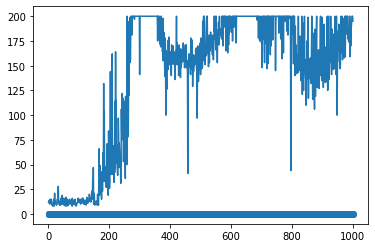

In [27]:
env = gym.make('CartPole-v0')
#best params
#gamma = 0.999 ,epsilon = 1.0, lr = 0.01, max_mem_size=10000, fc1 = 256, gc2 = 128,n_games=500, 
agent = Agent(gamma=0.8, epsilon=0.3, lr=0.001, tau = 0.3, max_mem_size=10000,
              input_dims = (4,), batch_size=128, n_actions=2, fc = True, fc1 = 256,fc2 = 128)

#store start values for decay
gamma_start = agent.gamma
epsilon_start = agent.epsilon
tau_start = agent.tau

scores, eps_history = [],[]
n_games = 1000

for i in range(n_games):
    score = 0
    done = False
    observation = env.reset()
    while not done:
        action = agent.choose_action(observation)
        observation_,reward,done,info = env.step(int(action))
        #env.render() uncomment if u want to see how agent is getting trained, but rendering at every step increases the time taken to get trained
        agent.store_actions(observation,action,observation_,reward,done)
        agent.learn()
        observation = observation_
        score+=reward
    scores.append(score)
    eps_history.append(agent.epsilon)
    avg_score = np.mean(scores[-100:])
    if i%50 == 0:
        print("episode : {} | score : {} | average score :{} | epsilon : {} | gamma : {} | tau : {}".format(
                                                                            i,score,avg_score,agent.epsilon, agent.gamma, agent.tau))
    #decay tau,gamma,epsilon
    agent.tau = decay(tau_start,i+1,0.01, constant = 0.001)
    agent.gamma = decay(gamma_start,i+1,0.999,mode='max', constant = 0.001)
    agent.epsilon = decay(epsilon_start,i+1,0.001,constant=0.001)

    if i%2==0:
        agent.train_targetnet()
        
T.save(agent.Q_eval.state_dict(),r'D:\AI\REINFORCEMENT_LEARNING\DQN\CartPole.pt')
x = [i+1 for i in range(n_games)]
plt.plot(x,scores)
plt.scatter(x,eps_history)
plt.savefig(r"D:\AI\REINFORCEMENT_LEARNING\DQN\lCurve_cartpole.png")   

In [ ]:
env = gym.make("SpaceInvaders-v0")
agent = Agent(gamma=0.8, epsilon=0.3, lr=0.001, tau=0.3, max_mem_size=10000,
              input_dims = (4,75,75), batch_size=128, n_actions=6, fc = False, fc1 = 256,fc2 = 128)

#store start values for decay
gamma_start = agent.gamma
epsilon_start = agent.epsilon
tau_start = agent.tau

scores, eps_history = [], []
n_games = 200

def preprocess(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image[25:200]
    image = cv2.resize(image,(75,75))
    image = image[np.newaxis,:,:]
    #image = image.transpose((2,0,1))
    return image

def decay(value ,time_step ,thr ,mode = 'min' ,constant=0.001):
    if mode=='max':
        constant = -1*constant
    value = value*np.exp(-constant*time_step)
    if mode=='max':
        return min(value,thr)
    else:
        return max(value,thr)

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0
    past_frames = [np.zeros((1,75,75)) for i in range(4)]
    past_frames[-1] = preprocess(observation)
    while not done:
        state = np.concatenate(past_frames,axis=0)
        action = agent.choose_action(state) 
        observation_, reward, done, info = env.step(int(action))
        
        past_frames.append(preprocess(observation))
        past_frames = past_frames[1:]

        state_ = np.concatenate(past_frames)
        agent.store_actions(state,action,state_,reward,done)
        agent.learn()

        score+=reward


    scores.append(score)
    eps_history.append(agent.epsilon)
    avg_score = np.mean(scores[-100:])
    if i%10==0:
        print("episode : {} | score : {} | average score :{} | epsilon : {} | gamma : {} | tau : {}".format(
                                                                            i,score,avg_score,agent.epsilon, agent.gamma, agent.tau))
    
    #decay tau,gamma,epsilon
    agent.tau = decay(tau_start,i+1,0.1)
    agent.gamma = decay(gamma_start,i+1,0.999,mode='max')
    agent.epsilon = decay(epsilon_start,i+1,0.001,constant=0.03)

    if i%2==0:
        agent.train_targetnet()

episode : 0 | score : 215.0 | average score :215.0 | epsilon : 0.3 | gamma : 0.8 | tau : 0.3
episode : 10 | score : 170.0 | average score :178.63636363636363 | epsilon : 0.22224546620451535 | gamma : 0.8080401336673344 | tau : 0.29701495012475043
episode : 20 | score : 220.0 | average score :157.85714285714286 | epsilon : 0.16464349082820792 | gamma : 0.8161610720214046 | tau : 0.2940596019920266
episode : 30 | score : 240.0 | average score :195.0 | epsilon : 0.12197089792217974 | gamma : 0.8243636271628136 | tau : 0.29113366006455244
episode : 40 | score : 315.0 | average score :224.02439024390245 | epsilon : 0.09035826357366064 | gamma : 0.8326486193539107 | tau : 0.2882368317456969
episode : 50 | score : 295.0 | average score :227.94117647058823 | epsilon : 0.06693904804452894 | gamma : 0.8410168771008193 | tau : 0.2853688273502142
episode : 60 | score : 235.0 | average score :237.21311475409837 | epsilon : 0.049589666466475966 | gamma : 0.8494692372362878 | tau : 0.2825293600752746